In [33]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
plt.style.use('seaborn-v0_8')
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix
import pickle

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# **Overview Dataset**

In [34]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df.head()

v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN

In [35]:
# Kích thước của DataFrame
df.shape

(5572, 5)

In [36]:
# Bỏ các cột không cần thiết
df = df[['v1', 'v2']]
df.columns = ['label', 'text'] # Chuẩn hóa tên cột


In [37]:
# Thông tin về DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [38]:
#Thống kê dữ liệu
df.describe()

label                    text
count   5572                    5572
unique     2                    5169
top      ham  Sorry, I'll call later
freq    4825                      30

In [39]:
df.dtypes


label    object
text     object
dtype: object

In [40]:
# Kiểm tra giá trị thiếu
df[['label', 'text']].isnull().sum().sum()

np.int64(0)

# **Trực quan hóa dữ liệu (trước khi được làm sạch)**

In [41]:
# 1. Kiểm tra trùng lặp bản ghi
duplicates = df['text'].duplicated().sum()
print(f"Số lượng bản ghi trùng lặp: {duplicates}")

Số lượng bản ghi trùng lặp: 403


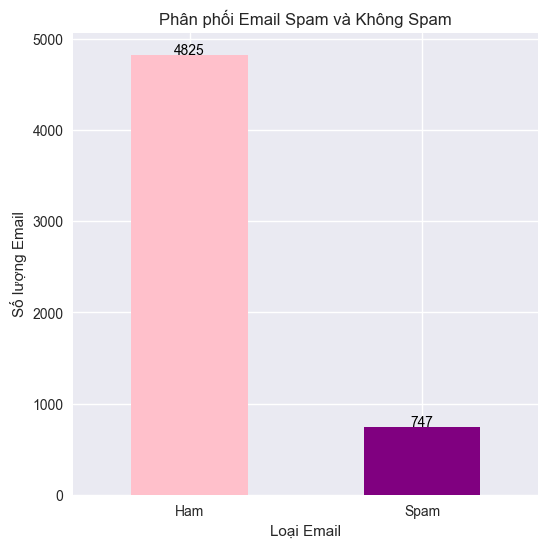

In [42]:
# 2. Phân phối nhãn trong cột 'v1' --> Mất cân bằng dữ liệu
email_counts = df['label'].value_counts()

plt.figure(figsize=(6, 6))
bars = email_counts.plot(kind='bar', color=['pink', 'purple'])
plt.title('Phân phối Email Spam và Không Spam')
plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam'], rotation=0)
plt.xlabel('Loại Email')
plt.ylabel('Số lượng Email')

for i, count in enumerate(email_counts):
    plt.text(i, count + 5, str(count), ha='center', fontsize=10, color='black')

plt.show()

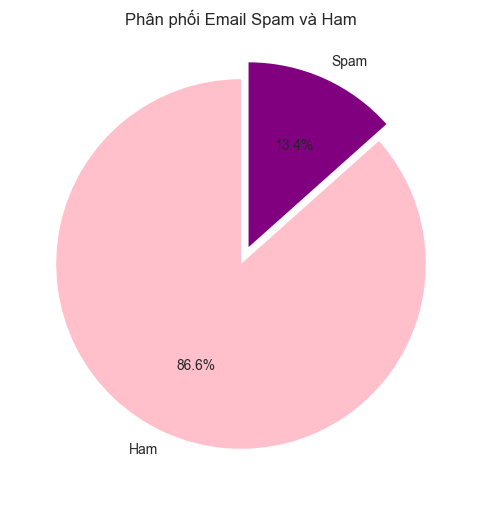

In [43]:
import matplotlib.pyplot as plt

# Số lượng email spam và ham
email_counts = df['label'].value_counts()

# Biểu đồ tròn
plt.figure(figsize=(6,6))
colors = ['pink', 'purple']  # Màu cho Ham và Spam
labels = ['Ham', 'Spam']     # Nhãn hiển thị

plt.pie(
    email_counts,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',  # Hiển thị phần trăm
    startangle=90,      # Bắt đầu từ góc 90 độ
    explode=(0, 0.1)    # Nhấn mạnh phần Spam (tách ra một chút)
)

plt.title('Phân phối Email Spam và Ham')
plt.show()


In [44]:
# 3. Kiểm tra số lượng từ trong từ điển email
all_text = " ".join(df['text'].tolist())

words = re.findall(r'\b\w+\b', all_text.lower())
vocab = set(words)
print(len(vocab))

8713


In [45]:
# 4. Tính độ dài câu theo số ký tự
df['length'] = df['text'].apply(len)

# Nhóm theo label và thống kê
stats = df.groupby('label')['length'].agg(['min', 'max', 'mean'])
print(stats)

       min  max        mean
label                      
ham      2  910   71.023627
spam    13  224  138.866131


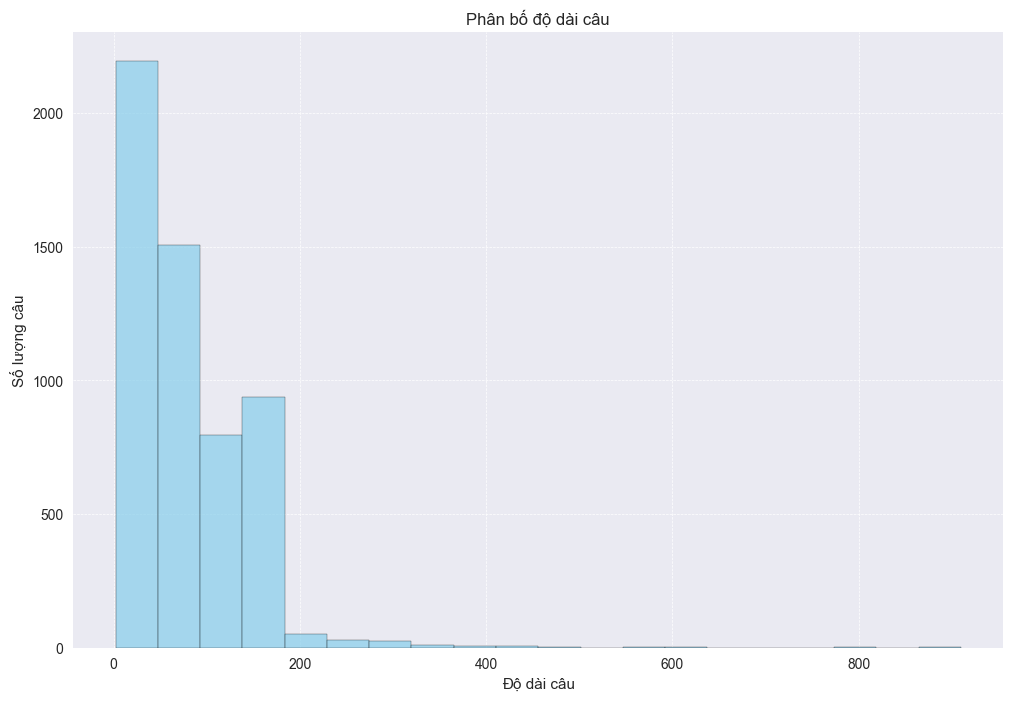

In [46]:
# 5. Phân bố độ dài câu
lengths = df['text'].apply(len)

plt.figure(figsize=(12, 8))
plt.hist(lengths, bins=20, edgecolor='k', alpha=0.7, color='skyblue')  # đổi màu ở đây

plt.title('Phân bố độ dài câu')           
plt.xlabel('Độ dài câu')                  
plt.ylabel('Số lượng câu')                 
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

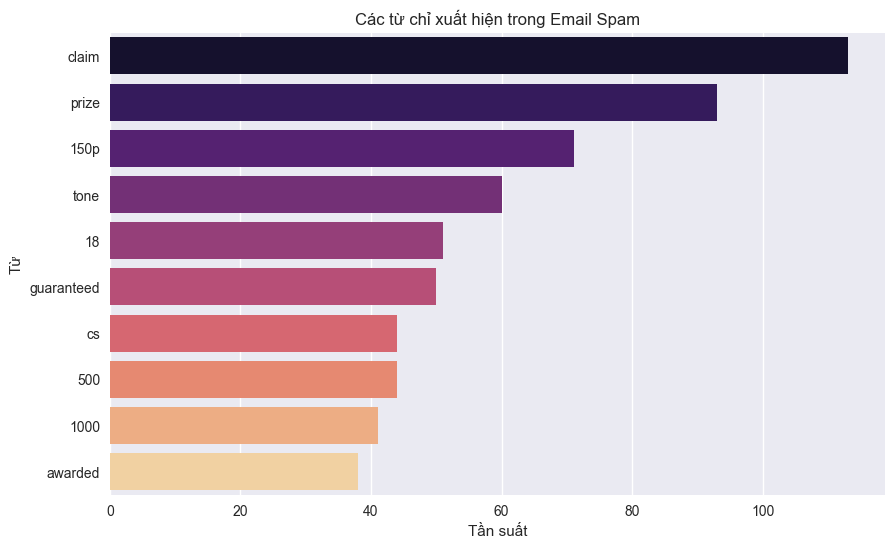

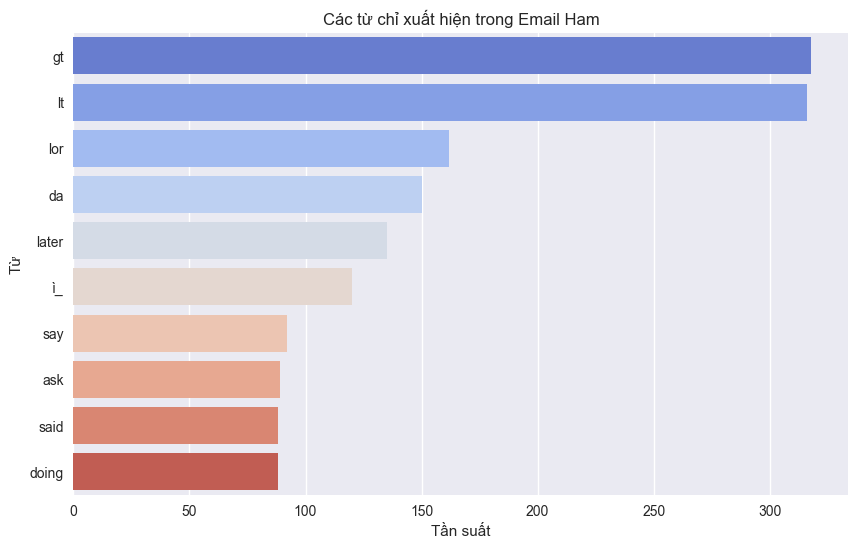

In [47]:
# 6. Trực quan các từ thường xuất hiện trong email (spam/ ham)(BOW)

# Chuyển văn bản thành Bag-of-Words
vectorizer = CountVectorizer(stop_words='english')
bow = vectorizer.fit_transform(df['text'])

bow_df = pd.DataFrame(bow.toarray(), columns=vectorizer.get_feature_names_out())
bow_df['label'] = df['label']

# Tách spam và ham
spam_emails = bow_df[bow_df['label'] == 'spam']
ham_emails  = bow_df[bow_df['label'] == 'ham']

# Tổng số lần xuất hiện từ trong từng nhóm
spam_word_counts = spam_emails.iloc[:, :-1].sum(axis=0)
ham_word_counts  = ham_emails.iloc[:, :-1].sum(axis=0)

# Từ chỉ xuất hiện trong spam hoặc ham
spam_only_words = spam_word_counts[ham_word_counts == 0].sort_values(ascending=False).head(10)
ham_only_words  = ham_word_counts[spam_word_counts == 0].sort_values(ascending=False).head(10)

# Biểu đồ: Từ chỉ xuất hiện trong spam
plt.figure(figsize=(10, 6))
sns.barplot(x=spam_only_words.values, y=spam_only_words.index, palette='magma')
plt.title('Các từ chỉ xuất hiện trong Email Spam')
plt.xlabel('Tần suất')
plt.ylabel('Từ')
plt.show()

# Biểu đồ: Từ chỉ xuất hiện trong ham
plt.figure(figsize=(10, 6))
sns.barplot(x=ham_only_words.values, y=ham_only_words.index, palette='coolwarm')
plt.title('Các từ chỉ xuất hiện trong Email Ham')
plt.xlabel('Tần suất')
plt.ylabel('Từ')
plt.show()


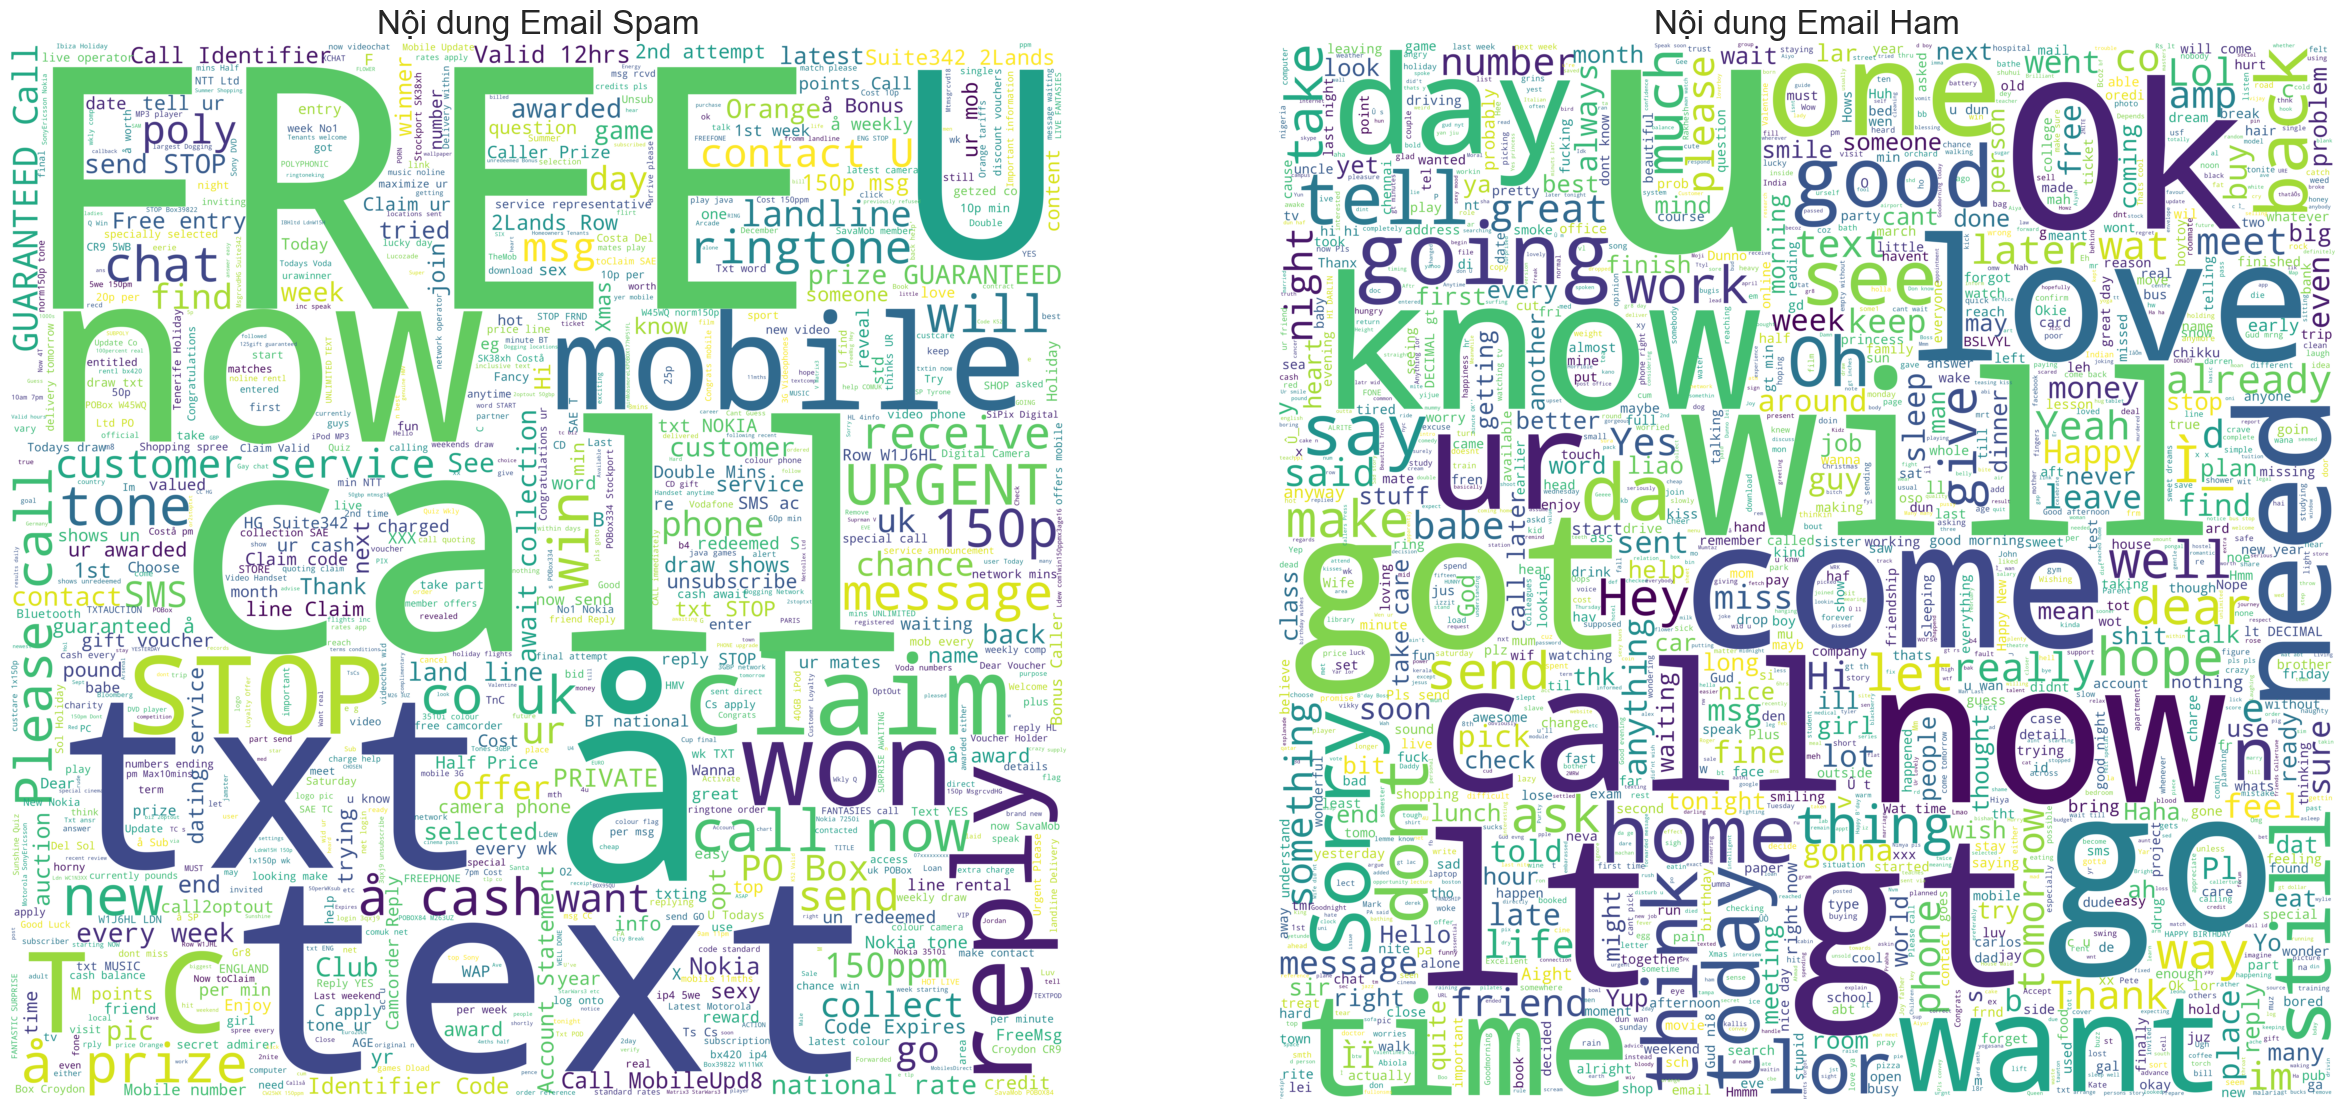

In [48]:
# 7. Trực quan từ cloud cho spam và ham

# Hàm vẽ wordcloud
def plot_wordcloud(text, title, position):
    wordcloud = WordCloud(
        max_font_size=256,
        max_words=8713, # Hiển thị tối đa 8713 từ
        background_color="white",
        scale=10,
        width=800,
        height=800,
        random_state=42
    ).generate(text)
    
    plt.subplot(1, 2, position)   
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title, fontsize=24)
    plt.axis("off")


# Ghép nội dung spam và ham thành chuỗi lớn
spam_text = ' '.join(df['text'][df['label'] == "spam"])
ham_text  = ' '.join(df['text'][df['label'] == "ham"])

# Vẽ
plt.figure(figsize=(30, 15))
plot_wordcloud(spam_text, "Nội dung Email Spam", 1)
plot_wordcloud(ham_text,  "Nội dung Email Ham", 2)
plt.show()

# **Data Processing**

In [49]:
# Xóa các bản ghi trùng lặp
df = df.drop_duplicates(subset='text').reset_index(drop=True)
df.shape

(5169, 3)

In [50]:
# Lưu số dòng ban đầu
original_shape = df.shape

# Lấy ngẫu nhiên 10 bản ghi
test_df = df.sample(n=10, random_state=42)

# Lưu ra file mới
test_df.to_csv('spam_test.csv', index=False, encoding='latin-1')

# Xóa các bản ghi này khỏi df gốc
df = df.drop(index=test_df.index).reset_index(drop=True)

# In kích thước trước và sau
print("Shape ban đầu:", original_shape)
print("Shape sau khi xóa 10 bản ghi:", df.shape)

Shape ban đầu: (5169, 3)
Shape sau khi xóa 10 bản ghi: (5159, 3)


In [51]:
# Kích thước của DataFrame
df.shape 

(5159, 3)

In [52]:
import nltk
nltk.download('punkt_tab')


# Tiền xử lý văn bản (làm sạch dữ liệu)
def clean_english_text(text):
    if pd.isna(text) or text == '' or not isinstance(text, str):
        return ''
    text = str(text)

    # 1. Lowercase
    text = text.lower()

    # 2. Remove emojis + special chars
    text = re.sub(r'[^a-z0-9\s]', ' ', text)

    # 3. Reduce repeated characters
    # e.g., heeellooo → helo
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # 4. Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # 5. Tokenize (English)
    text = word_tokenize(text)

    return ' '.join(text)

# Test clean_english_text
clean_english_text("OMG 😢😢!!! Call me at 123-456-7899 pleaaaaaseeee!!!!!")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


'omg call me at 123 456 7899 please'

In [53]:
clean_english_text(
    "OMG 😢😢!!! Call me at 123-456-7899 pleaaaaaseeee!!!!!"
)


'omg call me at 123 456 7899 please'

In [54]:
# Làm sạch cột 'text'
df['clean_text'] = df['text'].apply(clean_english_text)
df[['text', 'clean_text']].head(5)

text  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                          clean_text  
0  go until jurong point crazy available only in ...  
1                            ok lar joking wif u oni  
2  free entry in 2 a wkly comp to win fa cup fina...  
3        u dun say so early hor u c already then say  
4  nah i don t think he goes to usf he lives arou...

## **EDA - After cleaned**

In [55]:
# 1. Kiểm tra số lượng từ trong từ điển email sau khi làm sạch
all_text = " ".join(df['clean_text'].tolist())

words = re.findall(r'\b\w+\b', all_text.lower())
vocab = set(words)
print(len(vocab))

8591


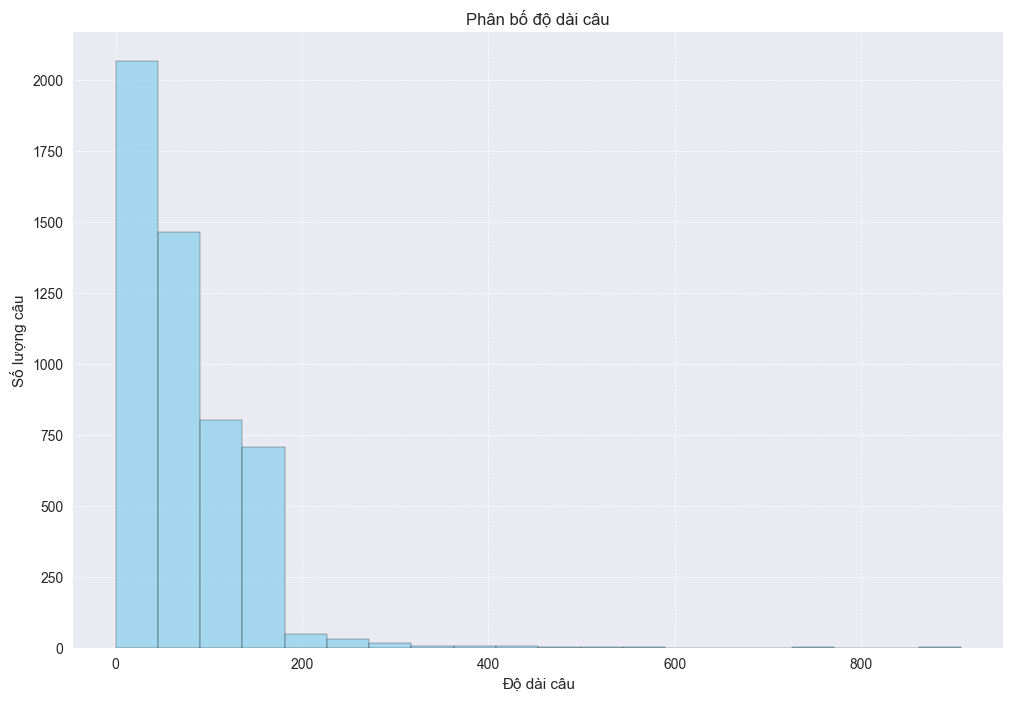

In [56]:
# 2. Phân bố độ dài câu sau khi làm sạch
lengths = df['clean_text'].apply(len)

plt.figure(figsize=(12, 8))
plt.hist(lengths, bins=20, edgecolor='k', alpha=0.7, color='skyblue')  # đổi màu ở đây

plt.title('Phân bố độ dài câu')           
plt.xlabel('Độ dài câu')                  
plt.ylabel('Số lượng câu')                 
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

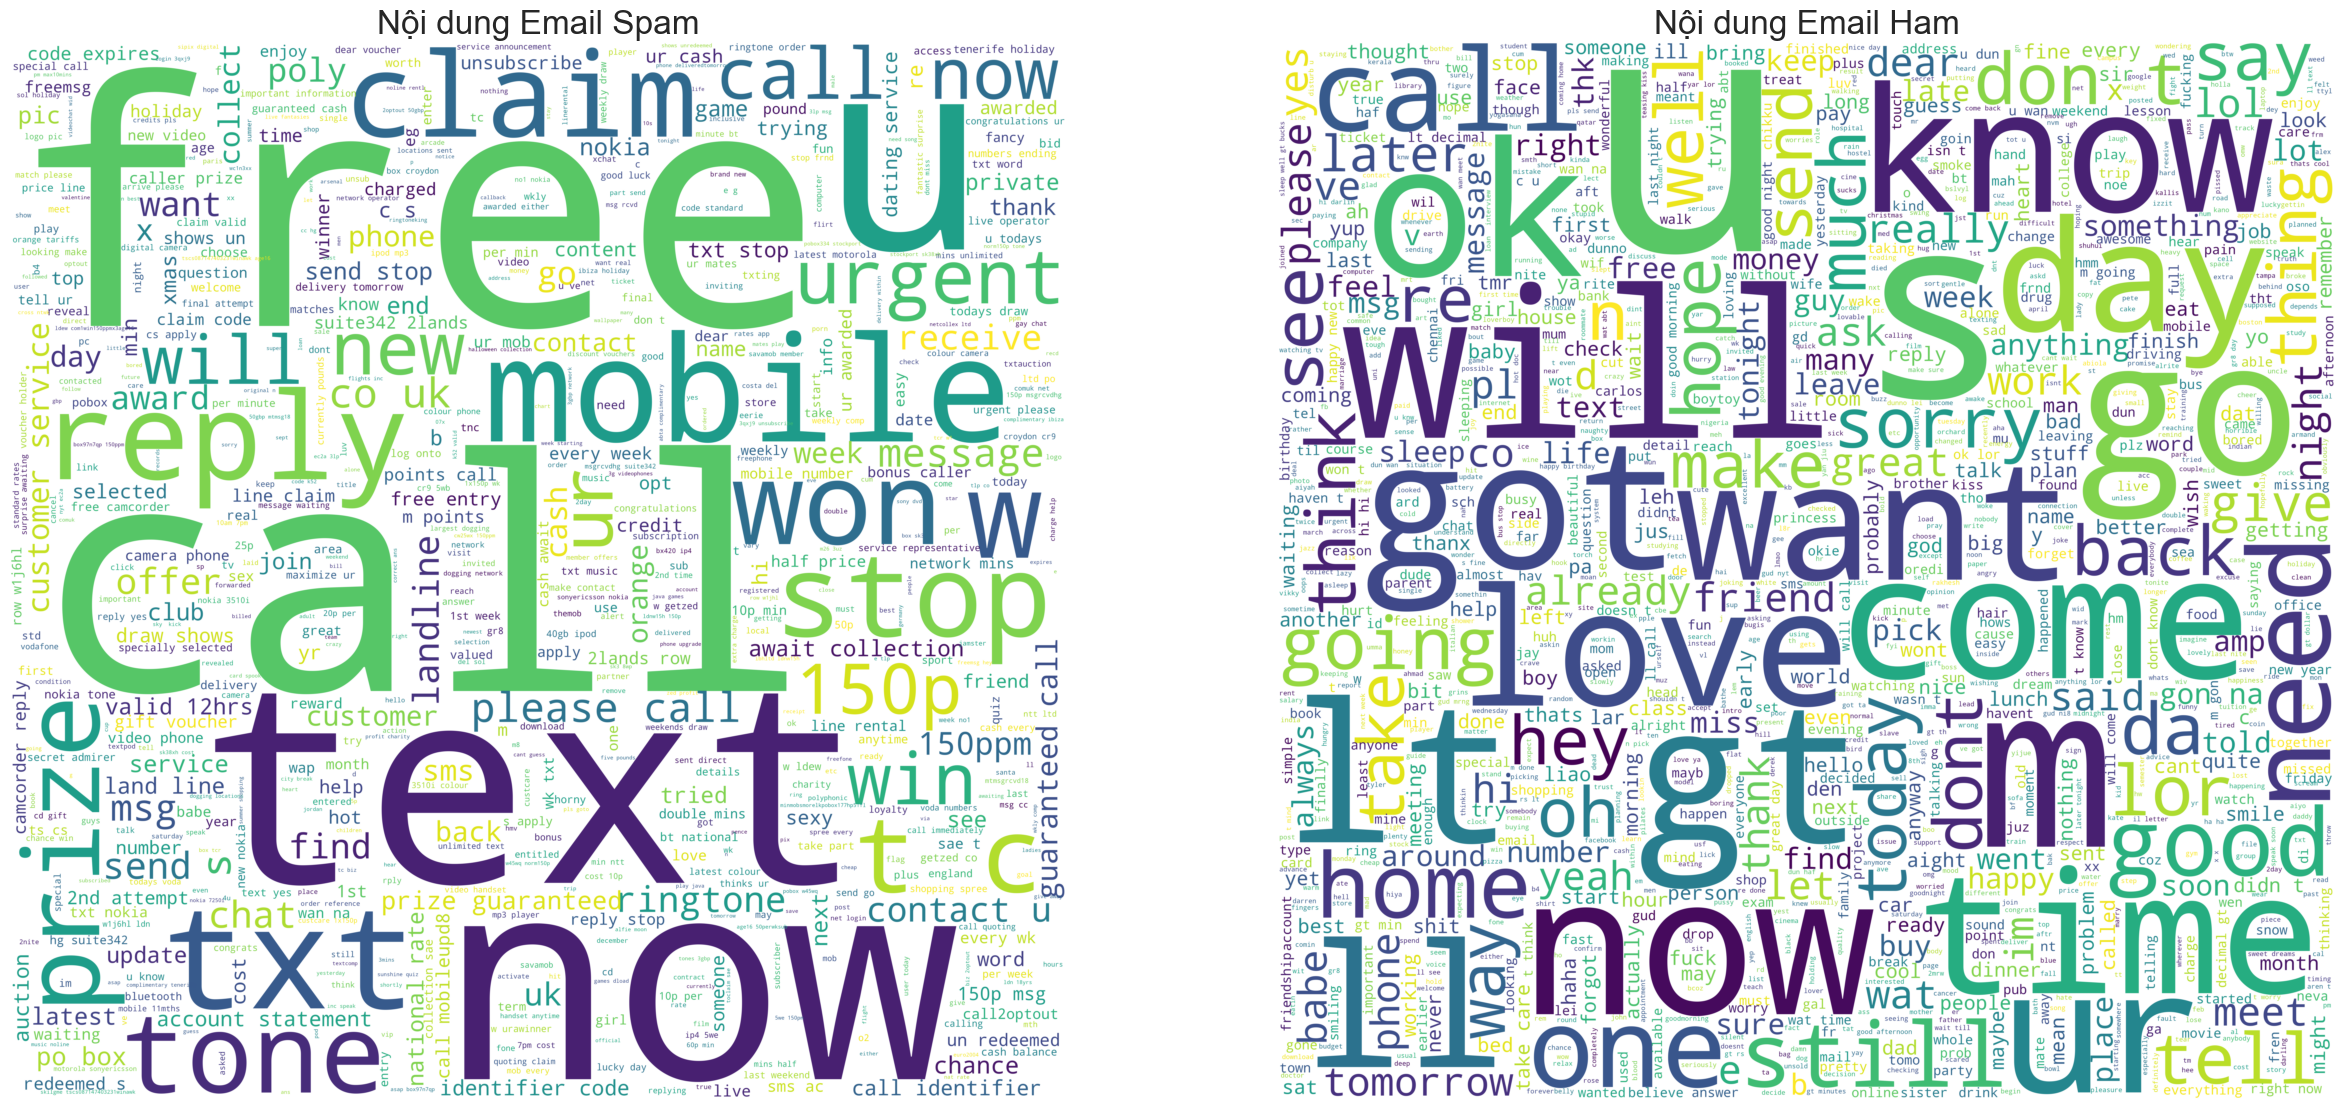

In [57]:
# 3. 


# Hàm vẽ wordcloud
def plot_wordcloud(text, title, position):
    wordcloud = WordCloud(
        max_font_size=256,
        max_words=8591, # Hiển thị tối đa 8591 từ
        background_color="white",
        scale=10,
        width=800,
        height=800,
        random_state=42
    ).generate(text)
    
    plt.subplot(1, 2, position)   
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title, fontsize=24)
    plt.axis("off")


# Ghép nội dung spam và ham thành chuỗi lớn
spam_text = ' '.join(df['clean_text'][df['label'] == "spam"])
ham_text  = ' '.join(df['clean_text'][df['label'] == "ham"])

# Vẽ
plt.figure(figsize=(30, 15))
plot_wordcloud(spam_text, "Nội dung Email Spam", 1)
plot_wordcloud(ham_text,  "Nội dung Email Ham", 2)
plt.show()

In [58]:
# .4 Tính độ dài câu theo số ký tự sau khi làm sạch
df['length'] = df['text'].apply(len)

# Nhóm theo label và thống kê
stats = df.groupby('label')['length'].agg(['min', 'max', 'mean'])
print(stats)

       min  max        mean
label                      
ham      2  910   70.450532
spam    13  224  137.973886


## **Text Representation**

### Phân chia tập dữ liệu (train/ test)

In [59]:
from sklearn.model_selection import train_test_split

train_email, test_email, train_labels, test_labels = train_test_split(
    df['clean_text'], 
    df['label'], 
    test_size=0.15, 
    stratify=df['label'],
    random_state=42
)

In [60]:
# Kích thước tập train và test
print(f"Số lượng bản ghi trong tập huấn luyện: {train_email.shape[0]}")
print(f"Số lượng bản ghi trong tập kiểm tra: {test_email.shape[0]}")

Số lượng bản ghi trong tập huấn luyện: 4385
Số lượng bản ghi trong tập kiểm tra: 774


## **Mã hóa dữ liệu: Bag of Words**

In [61]:
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(train_email)
X_test_bow = bow_vectorizer.transform(test_email)  

X_train_bow.shape

(4385, 7795)

## **Mã hóa dữ liệu: TF-IDF**

In [62]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_email)
X_test_tfidf = tfidf_vectorizer.transform(test_email) 

X_train_tfidf.shape

(4385, 7795)

### **Tăng cường dữ liệu với SMOTE**

In [63]:
from imblearn.over_sampling import SMOTE
# Chỉ áp dụng cho tập train
smote = SMOTE(random_state=42)

X_train_bow_smt, y_train_smt = smote.fit_resample(X_train_bow, train_labels)
X_train_tfidf_smt, y_train_smt = smote.fit_resample(X_train_tfidf, train_labels)

unique_labels, counts = np.unique(y_train_smt, return_counts=True)

for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count}")

Label ham: 3832
Label spam: 3832


In [64]:
print(f"Số lượng bản ghi trong tập huấn luyện sau khi áp dụng SMOTE: {X_train_bow_smt.shape[0]}")

Số lượng bản ghi trong tập huấn luyện sau khi áp dụng SMOTE: 7664


### **Chuẩn hóa dữ liệu: MaxAbsScaler**

In [65]:
bow_scaler = MaxAbsScaler()
X_train_bow_smt = bow_scaler.fit_transform(X_train_bow_smt)
X_test_bow = bow_scaler.transform(X_test_bow)

tfidf_scaler = MaxAbsScaler()
X_train_tfidf_smt = tfidf_scaler.fit_transform(X_train_tfidf_smt)
X_test_tfidf = tfidf_scaler.transform(X_test_tfidf)

In [66]:
import joblib

#joblib.dump(tfidf_scaler, "tfidf_scaler.pkl")


# **Huấn luyện mô hình**

In [67]:
# Hàm tạo mô hình máy học
def create_ml_model(model_type, **kwargs):
    models = {
        'naive_bayes': MultinomialNB,      
        'logistic_regression': LogisticRegression
    }
    model = models.get(model_type.lower())
         
    if model:
        # Remove random_state for models that don't support it
        if model_type.lower() == 'naive_bayes' and 'random_state' in kwargs:
            kwargs.pop('random_state')
        return model(**kwargs)
    else:
        supported_models = ", ".join(models.keys())
        print(f"Error: Model type '{model_type}' is not supported.\n"
              f"Supported models are: {supported_models}.\n"
              f"Please add your preferred model to create_model function.")
        return None
    
    
# Hàm tính toán kết quả
def calculate_results(y_true, y_pred, y_pred_proba=None):
    results = {
        "accuracy": accuracy_score(y_true, y_pred)*100,
        "precision": precision_score(y_true, y_pred, average='weighted'),
        "recall": recall_score(y_true, y_pred, average='weighted'),
        "f1": f1_score(y_true, y_pred, average='weighted')
    }
    
    if y_pred_proba is not None:
        roc_auc_scores = []
        y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
        for i in range(y_true_bin.shape[1]):
            roc_auc = roc_auc_score(y_true_bin[:, i], y_pred_proba[:, i])
            roc_auc_scores.append(roc_auc)
        
        results["roc_auc"] = np.mean(roc_auc_scores)
    
    return results

In [68]:
email_map = {
    1: "spam",
    0: "ham",
}

email_labels = ['spam', 'ham']  # Nhãn cho confusion matrix
df["label"] = df["label"].replace(email_map)


In [69]:
model_types = ['naive_bayes', 'logistic_regression']

#### **[1]. Huấn luyện dùng BOW**

=== TRAINING VỚI BoW FEATURES ===


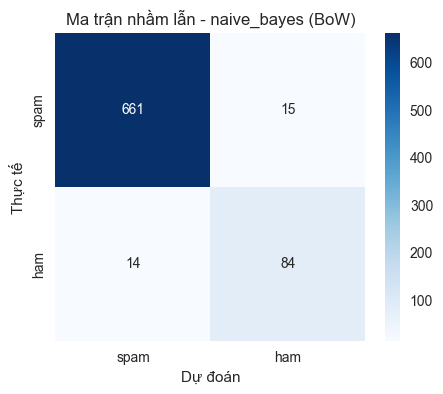

Model naive_bayes đã được lưu vào model/naive_bayes_bow_model.pkl


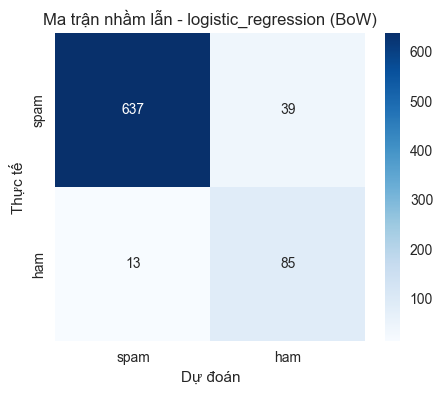

Model logistic_regression đã được lưu vào model/logistic_regression_bow_model.pkl


accuracy  precision    recall        f1   roc_auc                model  \
0  96.253230   0.962701  0.962532  0.962614  0.049224          naive_bayes   
1  93.281654   0.942710  0.932817  0.936092  0.064998  logistic_regression   

  feature  
0     BoW  
1     BoW

In [70]:
results_table_bow = []

print("=== TRAINING VỚI BoW FEATURES ===")
for model_type in model_types:
    model = create_ml_model(model_type)
    if model:
        model.fit(X_train_bow_smt, y_train_smt)
        y_pred = model.predict(X_test_bow)
        y_pred_proba = model.predict_proba(X_test_bow) if hasattr(model, 'predict_proba') else None
        result = calculate_results(test_labels, y_pred, y_pred_proba)
        result['model'] = model_type
        result['feature'] = 'BoW'
        
        results_table_bow.append(result)
        
        # Vẽ confusion matrix
        cm = confusion_matrix(test_labels, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=email_labels, yticklabels=email_labels)
        plt.title(f'Ma trận nhầm lẫn - {model_type} (BoW)')
        plt.xlabel('Dự đoán')
        plt.ylabel('Thực tế')
        plt.show()

        # Lưu model vào file pickle
        model_filename = f"model/{model_type}_bow_model.pkl"
        with open(model_filename, 'wb') as f:
            pickle.dump(model, f)
        print(f"Model {model_type} đã được lưu vào {model_filename}")

# Bảng kết quả
results_df_bow = pd.DataFrame(results_table_bow)
results_df_bow

#### **[2]. Huẩn luyện với TF-IDF**

=== TRAINING VỚI TF-IDF FEATURES ===


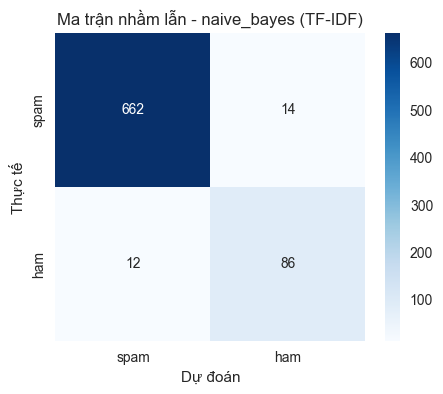

Model naive_bayes đã được lưu vào model/naive_bayes_tfidf_model.pkl


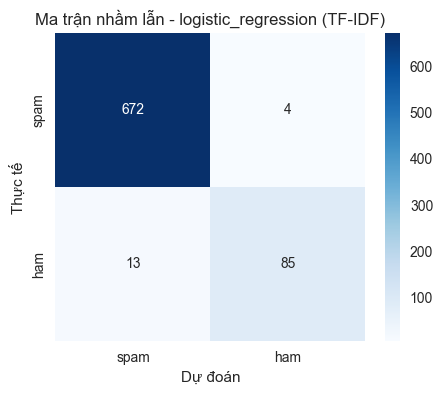

Model logistic_regression đã được lưu vào model/logistic_regression_tfidf_model.pkl


accuracy  precision    recall        f1   roc_auc                model  \
0  96.640827   0.966724  0.966408  0.966553  0.018491          naive_bayes   
1  97.803618   0.977734  0.978036  0.977580  0.008846  logistic_regression   

  feature  
0  TF-IDF  
1  TF-IDF

In [71]:
results_table_tfidf = []

print("=== TRAINING VỚI TF-IDF FEATURES ===")
for model_type in model_types:
    model = create_ml_model(model_type)
    if model:
        model.fit(X_train_tfidf_smt, y_train_smt)
        y_pred = model.predict(X_test_tfidf)
        y_pred_proba = model.predict_proba(X_test_tfidf) if hasattr(model, 'predict_proba') else None
        result = calculate_results(test_labels, y_pred, y_pred_proba)
        result['model'] = model_type
        result['feature'] = 'TF-IDF'
        
        results_table_tfidf.append(result)
        
        # Vẽ confusion matrix
        cm = confusion_matrix(test_labels, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=email_labels, yticklabels=email_labels)
        plt.title(f'Ma trận nhầm lẫn - {model_type} (TF-IDF)')
        plt.xlabel('Dự đoán')
        plt.ylabel('Thực tế')
        plt.show()

        # Lưu model vào file pickle
        model_filename = f"model/{model_type}_tfidf_model.pkl"
        with open(model_filename, 'wb') as f:
            pickle.dump(model, f)
        print(f"Model {model_type} đã được lưu vào {model_filename}")

# Bảng kết quả
results_df_tfidf = pd.DataFrame(results_table_tfidf)
results_df_tfidf

## **Bảng tổng hợp kết quả**

In [72]:
all_results = results_table_bow + results_table_tfidf
results_df_combined = pd.DataFrame(all_results)
results_df_combined.to_csv('model_results_combined.csv', index=False)

print("=== KẾT QUẢ TỔNG HỢP ===")
print("Kết quả tất cả mô hình (sắp xếp theo accuracy):")
print(results_df_combined.sort_values('accuracy', ascending=False))

# Model tốt nhất
best_model = results_df_combined.loc[results_df_combined['accuracy'].idxmax()]
print(f"\n--> Model tốt nhất: {best_model['model']} với {best_model['feature']}")
print(f"    Accuracy: {best_model['accuracy']:.4f}")

=== KẾT QUẢ TỔNG HỢP ===
Kết quả tất cả mô hình (sắp xếp theo accuracy):
    accuracy  precision    recall        f1   roc_auc                model  \
3  97.803618   0.977734  0.978036  0.977580  0.008846  logistic_regression   
2  96.640827   0.966724  0.966408  0.966553  0.018491          naive_bayes   
0  96.253230   0.962701  0.962532  0.962614  0.049224          naive_bayes   
1  93.281654   0.942710  0.932817  0.936092  0.064998  logistic_regression   

  feature  
3  TF-IDF  
2  TF-IDF  
0     BoW  
1     BoW  

--> Model tốt nhất: logistic_regression với TF-IDF
    Accuracy: 97.8036


**Kết quả cho thấy mã hóa với TF-IDF kết quả tốt hơn BOW bởi:**

- BOW chỉ đếm số lần xuất hiện → không biết từ nào quan trọng

    + Ví dụ: BOW chỉ đếm số lần xuất hiện → không biết từ nào quan trọng

- TF-IDF giảm trọng số của từ phổ biến → tăng trọng số của từ quan trọng, xử lý tốt cho các từ mang tính đặc trưng

    + Nếu từ xuất hiện nhiều trong mọi email → IDF thấp → trọng số về gần 0
     
        → ví dụ: “the”, "and", "you", "to", "a"

    + Nếu từ xuất hiện nhiều trong spam, ít trong ham → IDF cao

        → ví dụ: “free”, “win”, “credit”, “loan”, “click”, “prize”

-----------------------------------------------------------------------

## **Định nghĩa ma trận nhầm lẫn**

Ma trận nhầm lẫn dùng để đánh giá hiệu suất mô hình phân loại.

- Hàng (y-axis): lớp thực tế (Actual / Thực tế)

- Cột (x-axis): lớp dự đoán (Predicted / Dự đoán)

|      | Dự đoán Spam        | Dự đoán Ham         |
| ---- | ------------------- | ------------------- |
| Spam | True Positive (TP)  | False Negative (FN) |
| Ham  | False Positive (FP) | True Negative (TN)  |

##### **[1]. Ma trận đầu tiên: Naive Bayes (BoW)**

- 661: Spam thực tế được dự đoán đúng là spam → TP

- 15: Spam thực tế bị dự đoán nhầm là ham → FN

- 14: Ham thực tế bị dự đoán nhầm là spam → FP

- 84: Ham thực tế được dự đoán đúng là ham → TN

--> Nhận xét: Mô hình Naive Bayes với BoW dự đoán rất tốt, chỉ có một số email bị nhầm.

##### **[2]. Ma trận đầu tiên: Logistic Regression (BoW)**

- 637: TP

- 39: FN → nhiều hơn Naive Bayes

- 13: FP → ít hơn Naive Bayes

- 85: TN → nhiều hơn Naive Bayes

--> Nhận xét: Mô hình Naive Bayes với BoW dự đoán rất tốt, chỉ có một số email bị nhầm.

    - Naive Bayes: ưu thế dự đoán spam tốt hơn
    - Logistic Regression: ưu thế dự đoán ham chính xác hơn

##### **[1]. Ma trận đầu tiên: Naive Bayes (TF-IDF)**

- 662: Spam thực tế được dự đoán đúng là spam → TP

- 14: Spam thực tế bị dự đoán nhầm là ham → FN

- 12: Ham thực tế bị dự đoán nhầm là spam → FP

- 86: Ham thực tế được dự đoán đúng là ham → TN

--> Nhận xét: Mô hình Naive Bayes với BoW dự đoán rất tốt, chỉ có một số email bị nhầm.

##### **[2]. Ma trận đầu tiên: Logistic Regression (TF-IDF)**

- 672: TP

- 4: FN → ít hơn Naive Bayes

- 13: FP → nhiều hơn Naive Bayes

- 85: TN → ít hơn Naive Bayes

--> Nhận xét: Mô hình Naive Bayes với BoW dự đoán rất tốt, chỉ có một số email bị nhầm.

    - Naive Bayes: ưu thế dự đoán spam tốt hơn
    - Logistic Regression: ưu thế dự đoán ham chính xác hơn

In [73]:
joblib.dump(bow_vectorizer, "vectorizer/bow.pkl")
joblib.dump(tfidf_vectorizer, "vectorizer/tfidf.pkl")


['vectorizer/tfidf.pkl']

In [74]:
print(y_pred_proba[:50, 1])


[0.0234039  0.07699799 0.03116613 0.13097204 0.02252331 0.02253392
 0.01296562 0.00476719 0.01385214 0.01780145 0.0208696  0.24894033
 0.01821289 0.06614674 0.00380606 0.00998057 0.05861942 0.9970578
 0.00321329 0.01107907 0.01160008 0.01505324 0.0152705  0.00223932
 0.99245977 0.01789951 0.01514367 0.02253145 0.00558926 0.02745648
 0.00683116 0.01664961 0.00660961 0.0127034  0.00778921 0.00625949
 0.07370227 0.00668726 0.04438737 0.03565698 0.95841336 0.00335066
 0.01626948 0.12938815 0.03315705 0.00896336 0.00548393 0.03407981
 0.00139364 0.03833952]


# **Test inference/ trên 10 samples được chỉ định**

In [75]:
def infer_email_from_file(email_text, model_file, feature_type='BoW'):
    # Load model từ file
    with open(model_file, 'rb') as f:
        model = pickle.load(f)
    
    # Chọn vectorizer và scaler
    if feature_type.upper() == 'BOW':
        vectorizer = bow_vectorizer
        scaler = bow_scaler
    elif feature_type.upper() == 'TF-IDF':
        vectorizer = tfidf_vectorizer
        scaler = tfidf_scaler
    else:
        print("Feature type không hợp lệ. Chọn 'BoW' hoặc 'TF-IDF'.")
        return
    
    # Transform input
    X_input = vectorizer.transform([email_text])
    X_input = scaler.transform(X_input)
    
    # Dự đoán
    y_pred = model.predict(X_input)[0]
    print(f"Dự đoán: {email_map.get(y_pred, y_pred)}")
    print("Y predict: ",y_pred)
    print("email map:",email_map)
    # Xác suất nếu có
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_input)[0]
        print("y proba:",y_proba)
        for i, prob in enumerate(y_proba):
            if(i==0):
                proba_dict = {email_map[i+1]: f"{round(prob*100, 2)}%",email_map[i]:f"{100-round(prob*100, 2)}%" }
            proba_dict = {email_map[1]: f"{round(prob*100, 2)}%", email_map[0]:f"{100-round(prob*100, 2)}%"}
        print("Xác suất dự đoán:", proba_dict)
